In [1]:
##### Step 1: import functions #####
from keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, AveragePooling2D, Input
from keras.layers import MaxPooling2D, Dropout
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
import pickle
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import keras as keras
from numpy.random import seed; seed(111)
keras.utils.set_random_seed(123)
from sklearn.metrics import roc_curve, auc
from six import StringIO 
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from scipy.stats import ttest_ind
from IPython.display import Image  
import pydotplus
from keras.regularizers import L1L2
import os

In [2]:
os.chdir('../')

In [3]:
##### load data #####
allData = pd.compat.pickle_compat.load(open("DL_CyTOF/covid_bcell_allData.obj", "rb" ))
metaData = allData["cytof_files"]
cytoData = allData["expr_list"]
markerNames = allData["marker_names"]

In [4]:
metaData.head()

,file_name,sample_id,time_days,patient_id,condition,dataset,y
0,export_COVID19_994515 d7_Bcell.fcs,994515 d7,0,994515,COVID,train,1
1,export_COVID19_994516 d7_Bcell.fcs,994516 d7,0,994516,COVID,train,1
2,export_COVID19_994518 d7_Bcell.fcs,994518 d7,0,994518,COVID,train,1
3,export_COVID19_994519 d7_Bcell.fcs,994519 d7,0,994519,COVID,train,1
4,export_COVID19_994519_d21_Bcell.fcs,994519_d21,21,994519,COVID,test,1


In [5]:
##### split train and test######
##### Step 3: split train and test######
y = metaData.y.values
x = cytoData

train_id = metaData.dataset =="train"
test_id = metaData.dataset =="test"

x_train = x[train_id]; y_train = y[train_id]
x_test = x[test_id]; y_test = y[test_id]

In [6]:
len(y_test)

62

In [7]:
# input
model_input = Input(shape=x_train[0].shape)

# first convolution layer
model_output = Conv2D(3, kernel_size=(1, x_train.shape[2]),
                 activation=None)(model_input)
model_output = BatchNormalization()(model_output)
model_output = Activation("relu")(model_output)

# sceond convolution layer
model_output = Conv2D(3, (1, 1), activation=None)(model_output)
model_output = BatchNormalization()(model_output)
model_output = Activation("relu")(model_output)

# pooling layer
model_output = AveragePooling2D(pool_size=(x_train.shape[1], 1))(model_output)
model_output = Flatten()(model_output)

# Dense layer
model_output = Dense(3, activation=None)(model_output)
model_output = BatchNormalization()(model_output)
model_output = Activation("relu")(model_output)

# output layer
model_output = Dense(1, activation=None)(model_output)
model_output = BatchNormalization()(model_output)
model_output = Activation("sigmoid")(model_output)

In [8]:
##### Step 5: Fit model #####
# specify input and output
model = Model(inputs=[model_input],
              outputs=model_output)

# define loss function and optimizer
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.01),
              metrics=['accuracy'])

# save the best performing model
checkpointer = ModelCheckpoint(filepath='DL_CyTOF/bcell_saved_weights.hdf5', 
                               monitor='val_loss', verbose=1, 
                               save_best_only=True)
earlyStop = EarlyStopping(monitor='val_loss', patience=100, mode='auto')

# model training
model.fit([x_train], y_train,
          batch_size=60,
          epochs=500, 
          verbose=1,
          callbacks=[checkpointer, earlyStop],
          validation_split=0.3)

Epoch 1/500


/opt/anaconda3/envs/CyTOF_DL/lib/python3.11/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2024-12-12 15:06:15.042924: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/2 [==============>...............] - ETA: 0s - loss: 0.8040 - accuracy: 0.4500
Epoch 1: val_loss improved from inf to 0.71589, saving model to DL_CyTOF/bcell_saved_weights.hdf5
2/2 [==============================] - 0s 105ms/step - loss: 0.8023 - accuracy: 0.4245 - val_loss: 0.7159 - val_accuracy: 0.2391
Epoch 2/500
1/2 [==============>...............] - ETA: 0s - loss: 0.7871 - accuracy: 0.4000
Epoch 2: val_loss did not improve from 0.71589
2/2 [==============================] - 0s 36ms/step - loss: 0.7854 - accuracy: 0.4434 - val_loss: 0.7289 - val_accuracy: 0.1522
Epoch 3/500
1/2 [==============>...............] - ETA: 0s - loss: 0.7724 - accuracy: 0.4167
Epoch 3: val_loss did not improve from 0.71589
2/2 [==============================] - 0s 35ms/step - loss: 0.7657 - accuracy: 0.3868 - val_loss: 0.7437 - val_accuracy: 0.1522
Epoch 4/500
1/2 [==============>...............] - ETA: 0s - loss: 0.7580 - accuracy: 0.3833
Epoch 4: val_loss did not improve from 0.71589
2/2 [===========

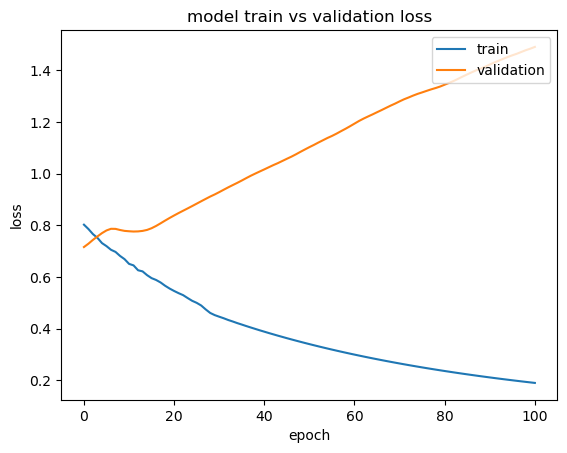

In [9]:
# plot train and validation loss
#model.save('result_11_weights.hdf5')

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [10]:
best_model = load_model('DL_CyTOF/bcell_saved_weights.hdf5')

# print result of the best model
score = best_model.evaluate([x_train], y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

# score = best_model.evaluate([x_valid], y_valid, verbose=0)
# print('Valid loss:', score[0])
# print('Valid accuracy:', score[1])

score = best_model.evaluate([x_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.6777008771896362
Train accuracy: 0.7039473652839661
Test loss: 0.6779135465621948
Test accuracy: 0.725806474685669


2/2 [==============================] - 0s 5ms/step


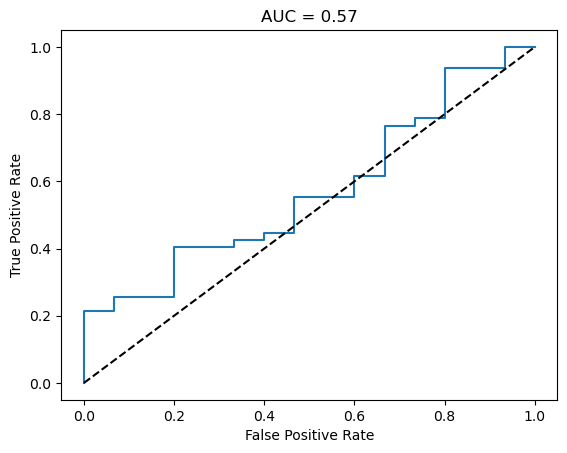

In [11]:
# generate ROC and AUC
y_scores = best_model.predict([x_test])
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC = {0:.2f}'.format(roc_auc))
plt.show()

In [12]:
y_scores = pd.DataFrame(np.column_stack([list(y_test), list(y_scores.flatten())]), columns=['truth', 'pred'])
y_scores.to_csv('data/bcell_deep_cytof_aucs.csv', sep=',')

# Fit CNN Model

In [13]:
##### define model #####
coeff_l1 = 0
coeff_l2 = 1e-4
model_input = Input(shape=x_train[0].shape)
model_output = Conv2D(5, kernel_size=(1, x_train.shape[2]),
                 activation='linear', 
                      kernel_regularizer=L1L2(l1=coeff_l1, l2=coeff_l2))(model_input)
#model_output = BatchNormalization()(model_output)
model_output = Activation("relu")(model_output)
# model_output = Dropout(0.2)(model_output)

model_output = MaxPooling2D(pool_size=(10000, 1))(model_output)
model_output = Flatten()(model_output)

model_output = Dense(1, activation=None, kernel_regularizer=L1L2(l1=coeff_l1, l2=coeff_l2))(model_output)
model_output = Activation("sigmoid")(model_output)

model = Model(inputs=[model_input],
                           outputs=model_output)
model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=0.01),
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='DL_CyTOF/bcell_cell_cnn_saved_weights.hdf5', monitor='val_loss', 
                                               verbose=1, save_best_only=True)
earlyStop = EarlyStopping(monitor='val_loss', patience=100, mode='auto', restore_best_weights=True)

/opt/anaconda3/envs/CyTOF_DL/lib/python3.11/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
# model training
model.fit([x_train], y_train,
          batch_size=60,
          epochs=200,
          verbose=1,
          callbacks=[checkpointer,earlyStop],
          validation_split=0.3)

Epoch 1/200
1/2 [==============>...............] - ETA: 0s - loss: 18.4129 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 2.19488, saving model to DL_CyTOF/bcell_cell_cnn_saved_weights.hdf5
2/2 [==============================] - 0s 69ms/step - loss: 17.4477 - accuracy: 0.0000e+00 - val_loss: 2.1949 - val_accuracy: 0.8478
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 13.7234 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 2.19488 to 1.54971, saving model to DL_CyTOF/bcell_cell_cnn_saved_weights.hdf5
2/2 [==============================] - 0s 27ms/step - loss: 12.6928 - accuracy: 0.0000e+00 - val_loss: 1.5497 - val_accuracy: 0.8478
Epoch 3/200
1/2 [==============>...............] - ETA: 0s - loss: 9.4696 - accuracy: 0.0000e+00
Epoch 3: val_loss improved from 1.54971 to 1.00544, saving model to DL_CyTOF/bcell_cell_cnn_saved_weights.hdf5
2/2 [==============================] - 0s 27ms/step - loss: 8.6135 - accuracy: 0.0000e+00 - val_loss: 1.0054 - v

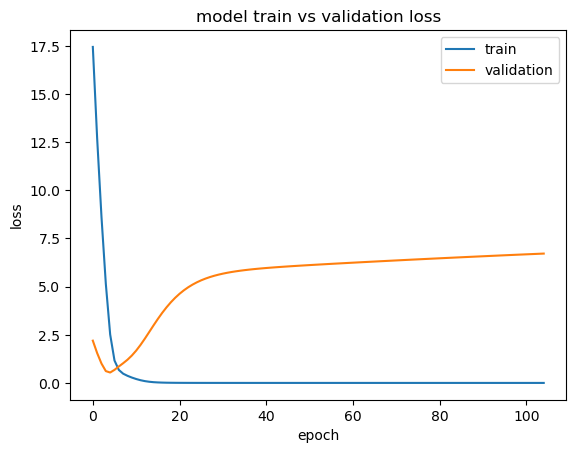

In [15]:
# plot train and validation loss
#model.save('result_11_weights.hdf5')

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [16]:
best_model = load_model('DL_CyTOF/bcell_cell_cnn_saved_weights.hdf5')

# print result of the best model
score = best_model.evaluate([x_train], y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

# score = best_model.evaluate([x_valid], y_valid, verbose=0)
# print('Valid loss:', score[0])
# print('Valid accuracy:', score[1])

score = best_model.evaluate([x_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 1.0840771198272705
Train accuracy: 0.3947368562221527
Test loss: 1.1091272830963135
Test accuracy: 0.4032258093357086


2/2 [==============================] - 0s 4ms/step


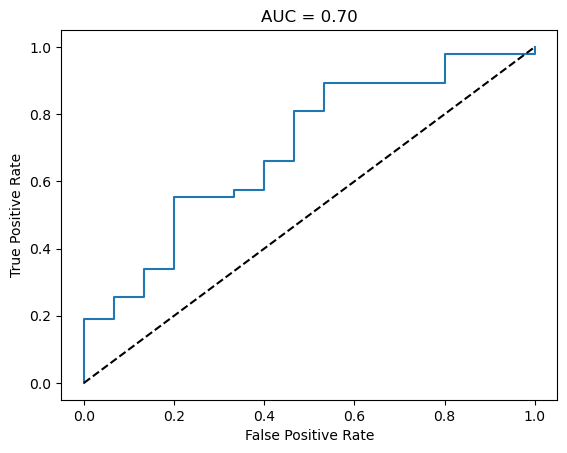

In [17]:
# generate ROC and AUC
y_scores = best_model.predict([x_test])
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC = {0:.2f}'.format(roc_auc))
plt.show()

In [18]:
y_scores = pd.DataFrame(np.column_stack([list(y_test), list(y_scores.flatten())]), columns=['truth', 'pred'])
y_scores.to_csv('data/bcell_cell_cnn_aucs.csv', sep=',')